In [2]:
from stackapi import StackAPI
import requests
from langdetect import detect
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from nltk.corpus import stopwords
import nltk
from wordcloud import WordCloud
import gensim
from gensim import corpora
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

In [1]:
def df_save(min_score=15, min_tags=2, max_tags=6, min_title_length=10, max_title_length=100, save_path="data.csv"):
    SITE = StackAPI('stackoverflow')
    SITE.max_pages = 25
    SITE.page_size = 100
    
    try:
        df_existing = pd.read_csv(save_path)
        all_data = df_existing.to_dict('records')
        print(f"Reprise de la collecte. {len(df_existing)} lignes déjà récupérées.")
        current_min_score = df_existing['score'].min()
    except FileNotFoundError:
        all_data = []
    
    start_date = datetime.datetime(2020, 1, 1)
    end_date = datetime.datetime(2023, 10, 1)
    
    delta = datetime.timedelta(days=60)
    
    current_start = start_date
    
    while current_start < end_date:
        print("start")
        current_end = min(current_start + delta, end_date)

        fromdate = int(current_start.timestamp())
        todate = int(current_end.timestamp())
    
        try:

            questions = SITE.fetch('questions',
                                   fromdate=fromdate,
                                   todate=todate,
                                   min=min_score,
                                   sort='votes',
                                   )
        except Exception as e:
            print(f"Error fetching questions from {current_start} to {current_end}: {e}")
            time.sleep(5)
            continue
        
        data = []
        print("questions")
        for question in questions['items']:

            if (min_tags <= len(question.get('tags', [])) <= max_tags and
                min_title_length <= len(question.get('title', '')) <= max_title_length):
                data.append({
                    'title': question['title'],
                    'score': question['score'],
                    'tags': ','.join(question['tags']),
                    'creation_date': datetime.datetime.fromtimestamp(question['creation_date']).isoformat(),
                })
        all_data.extend(data)
        print("extend")
        df_filtered = pd.DataFrame(all_data)
        df_filtered.to_csv(save_path, index=False)
        print(f"{len(data)} lignes récupérées de {current_start} à {current_end}.")
        print(f"{len(all_data)} lignes sauvegardées dans {save_path}.")       
    
        current_start = current_end
        time.sleep(0.2)


Possible Filter to get consistant data for tag prediction :
- By the score
- by the number of tags
- Temporality
- title(question) size
- by the popularity(view)
- language
- 

In [ ]:
df = df_save()

In [3]:
df = pd.read_csv("data.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17193 entries, 0 to 17192
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          17193 non-null  object
 1   score          17193 non-null  int64 
 2   tags           17193 non-null  object
 3   creation_date  17193 non-null  object
dtypes: int64(1), object(3)
memory usage: 537.4+ KB


In [5]:
df.describe()

,score
count,17193.000000
mean,32.564299
std,40.968594
min,15.000000
25%,17.000000
50%,22.000000
75%,33.000000
max,2430.000000


delete 22 dup due to api limitation

In [6]:
df.drop_duplicates('title', inplace=True)
df.duplicated('title').sum()

0

In [50]:
class TextPreprocessor:
    def __init__(self, df, commun=3):
        self.df = df
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.commun = commun

    def is_english(self, text):
        try:
            return detect(text) == 'en'
        except:
            return False

    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        words = text.split()
        words = [word for word in words if word not in self.stop_words]
        return ' '.join(words)

    def clean_common(self, text, frequent_words):
        words = text.split()
        words = [word for word in words if word not in frequent_words]
        return ' '.join(words)

    def lemmatize_text(self, text):
        lemmatized_words = [self.lemmatizer.lemmatize(word) for word in text]
        return lemmatized_words

    def dl(self, text):
        return [len(text)]

    def prepare_for_lda(self):
        self.df['cleaned_title_split'] = self.df['cleaned_title'].apply(lambda x: x.split() if isinstance(x, str) else x)
        dictionary = corpora.Dictionary(self.df['cleaned_title_split'])
        self.df.loc[:, 'corpus'] = [dictionary.doc2bow(text) for text in self.df['cleaned_title_split']]
        return dictionary

    def clean_df(self):
        nltk.download('wordnet')
        self.df['is_english'] = self.df['title'].apply(self.is_english)
        self.df= self.df[self.df['is_english'] == True].copy()
        self.df.loc[:, 'cleaned_title'] = self.df['title'].apply(lambda x: self.clean_text(x))
        self.plot_words()
        all_words = [word for title in self.df['cleaned_title'].str.split() for word in title]
        words, counts = zip(*Counter(all_words).most_common(self.commun))
        print(words)
        self.df.loc[:, 'cleaned_title'] = self.df['cleaned_title'].apply(lambda x: self.clean_common(x, words))
        self.plot_words()
    
    def transform(self):
        self.clean_df()
        dictionary = self.prepare_for_lda()
        self.df.loc[:, 'lm'] = self.df['cleaned_title'].apply(lambda x: self.lemmatize_text(x))
        return self.df, dictionary
    
    def plot_WordCloud(self):
        if 'cleaned_title' not in self.df.columns:
            all_words = [word for title in self.df['title'] \
                if isinstance(title, str) for word in title.split()]
        else:
            all_words = [word for title in self.df['cleaned_title'] \
                if isinstance(title, str) for word in title.split()]
        c = Counter(all_words)
        word_counts = {word: count for word, count in c.items()}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of Most Frequent Words in Titles', fontsize=16)
        plt.show()   
        
    def plot_words(self):
        if 'cleaned_title' not in self.df.columns:
            all_words = [word for title in self.df['title'].str.split() for word in title]
        else:
            all_words = [word for title in self.df['cleaned_title'].str.split() for word in title]
        words, counts = zip(*Counter(all_words).most_common(20))
        plt.figure(figsize=(10, 6))
        plt.bar(words, counts, color='skyblue')
        plt.title('Top 20 Most Frequent Words in Titles', fontsize=16)
        plt.ylabel('Frequency', fontsize=12)
        plt.xlabel('Words', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.tight_layout()
        plt.show()

    def plot_tags(self):
        if 'tags_split' not in self.df.columns:
            self.df['tags_split'] = self.df['tags'].str.split(',')
        all_tags = [tag for sublist in self.df['tags_split'] for tag in sublist]
        tag_counts = pd.Series(all_tags).value_counts()
        plt.figure(figsize=(12, 6))
        tag_counts.head(30).plot(kind='bar')
        plt.title('Top 30 Most Frequent Tags')
        plt.ylabel('Frequency')
        plt.xlabel('Tags')
        plt.xticks(rotation=70)
        plt.tight_layout()
        plt.show()
        
    def boxplot_scores(self):
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=self.df, x='score')
        plt.title('Boxplot of Question Scores')
        plt.xlabel('Score')
        plt.show()
    def get_data(self):
        return self.df

In [51]:
TP = TextPreprocessor(df.copy())


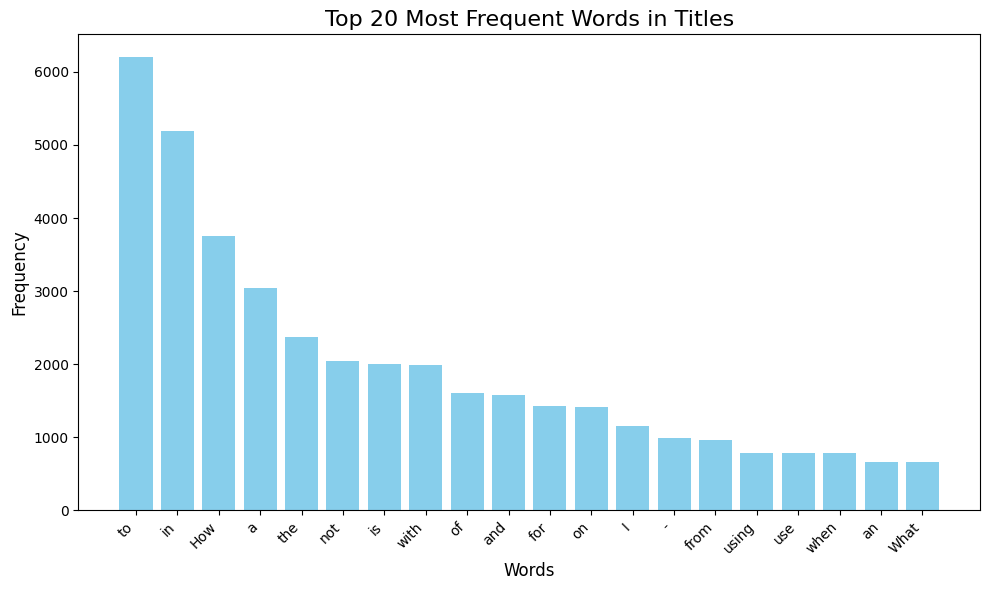

In [45]:
TP.plot_words()

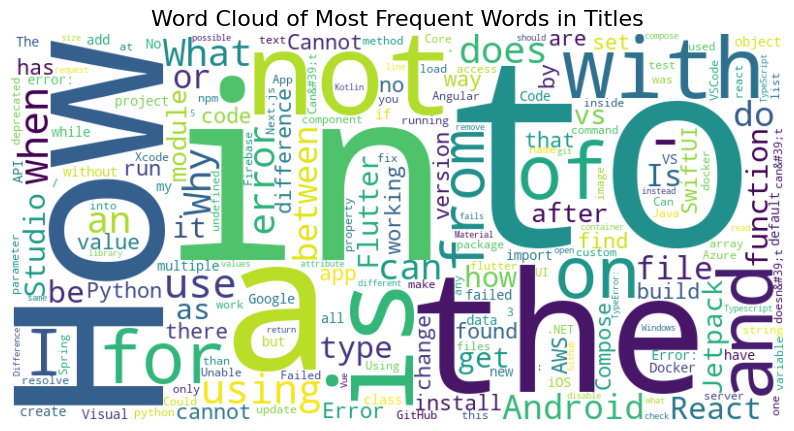

In [46]:
TP.plot_WordCloud()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\milan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


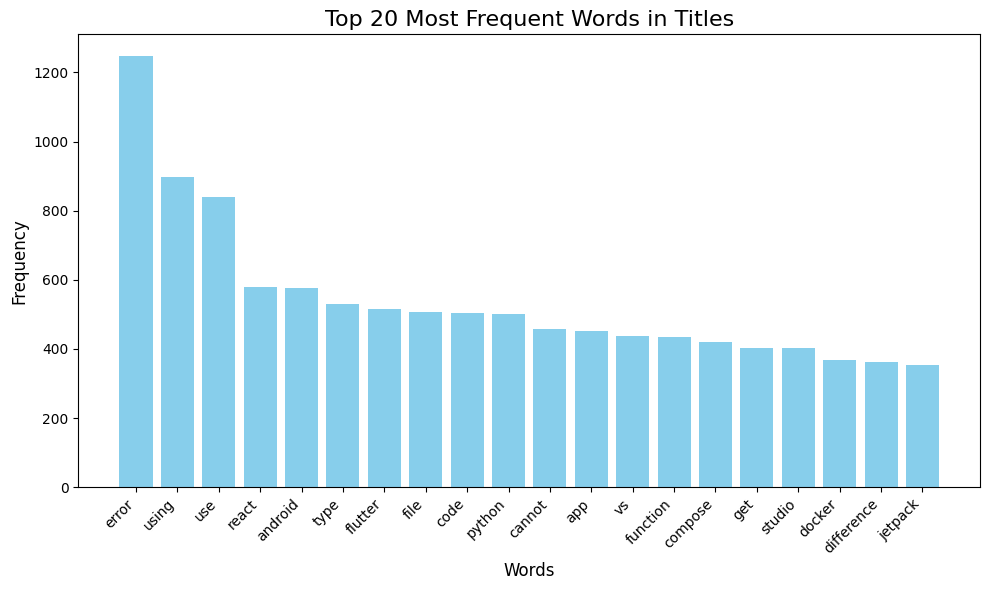

('error', 'using', 'use')


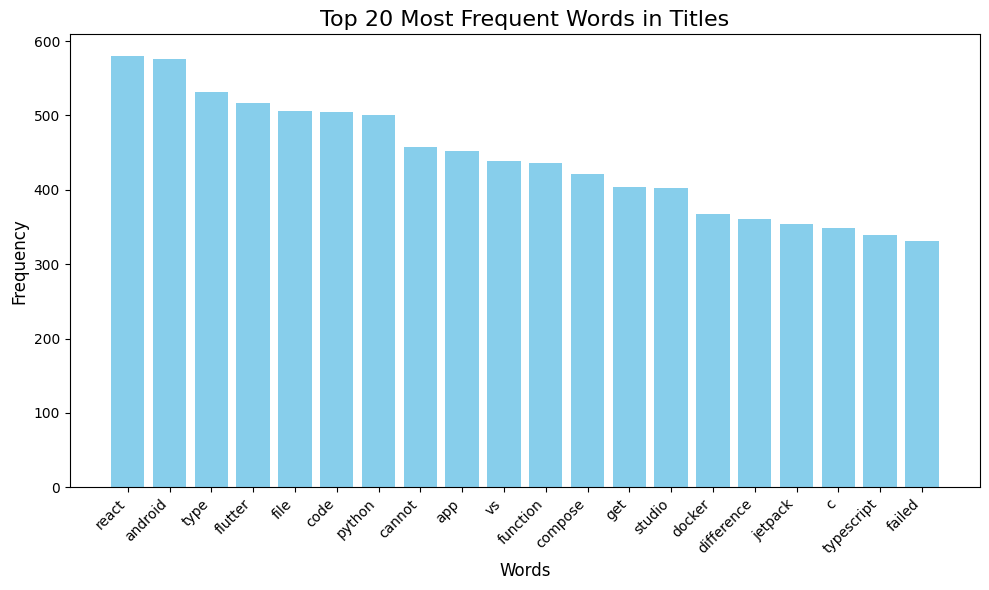

In [52]:
TP.transform()
print("\n")

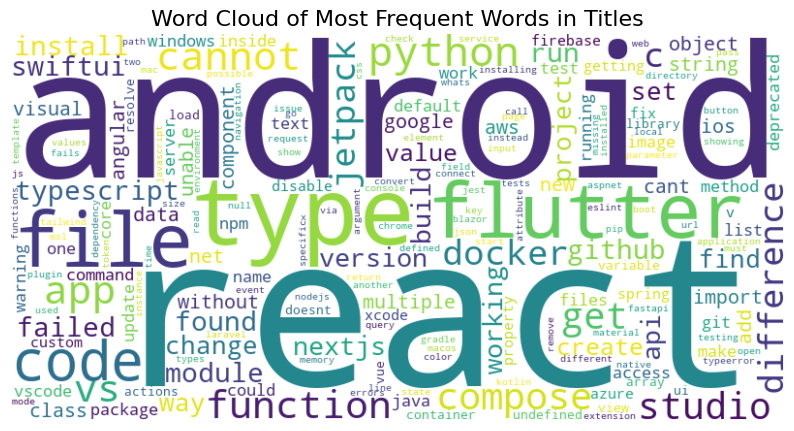

In [53]:
TP.plot_WordCloud()

In [48]:
X_clean = TP.get_data()
X_clean.head()

,title,score,tags,creation_date,is_english,cleaned_title,cleaned_title_split,corpus,lm
0,Is there a compatibility list for Angular / An...,410,"node.js,angular,angular-cli",2020-02-16T13:28:52,True,compatibility list angular angularcli nodejs,"[compatibility, list, angular, angularcli, nod...","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]","[c, o, m, p, a, t, i, b, i, l, i, t, y, , l, ..."
1,How can I use optional chaining with arrays an...,320,"javascript,arrays,typescript,function,optional...",2020-01-07T08:05:02,True,optional chaining arrays functions,"[optional, chaining, arrays, functions]","[(5, 1), (6, 1), (7, 1), (8, 1)]","[o, p, t, i, o, n, a, l, , c, h, a, i, n, i, ..."
2,What is the use of PYTHONUNBUFFERED in docker ...,308,"django,docker,dockerfile",2020-01-19T17:23:11,True,pythonunbuffered docker file,"[pythonunbuffered, docker, file]","[(9, 1), (10, 1), (11, 1)]","[p, y, t, h, o, n, u, n, b, u, f, f, e, r, e, ..."
5,How to Set port in next.js,284,"javascript,reactjs,npm,port,next.js",2020-02-10T10:33:48,True,set port nextjs,"[set, port, nextjs]","[(12, 1), (13, 1), (14, 1)]","[s, e, t, , p, o, r, t, , n, e, x, t, j, s]"
7,No version of NDK matched the requested version,249,"android,android-ndk,android-gradle-plugin,andr...",2020-02-26T00:02:53,True,version ndk matched requested version,"[version, ndk, matched, requested, version]","[(15, 1), (16, 1), (17, 1), (18, 2)]","[v, e, r, s, i, o, n, , n, d, k, , m, a, t, ..."


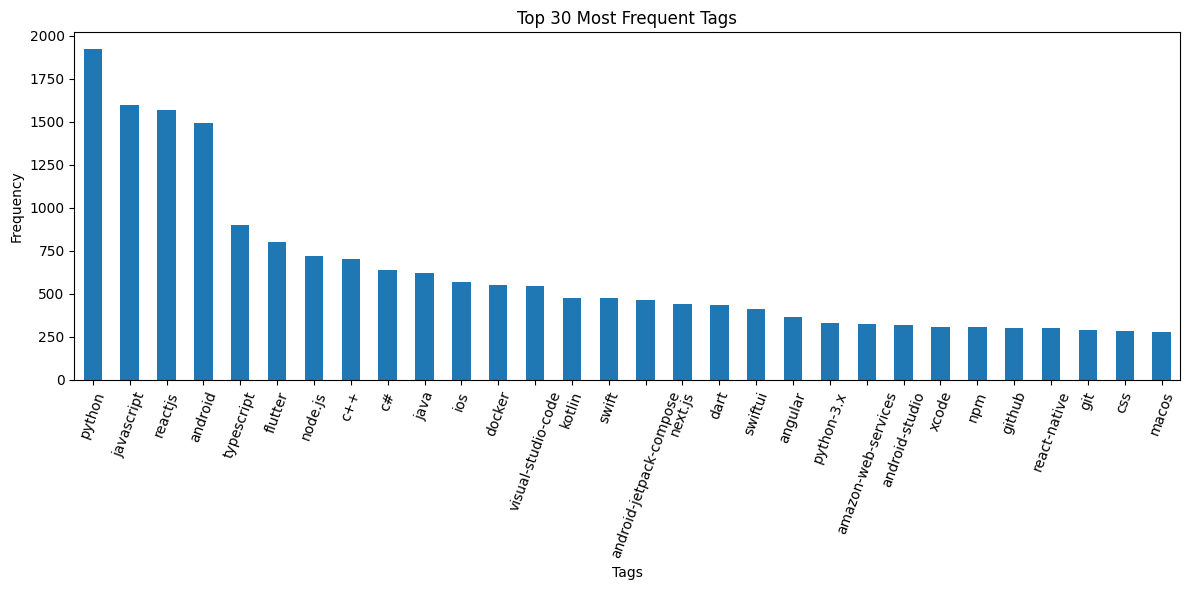

In [54]:
TP.plot_tags()